# BlackJack : Monte-Carlo with Exploring Start
## 추가 과제

----

## 0. Package
먼저 본 프로그램에서 사용할 Package를 Import합니다.

In [27]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

## 1. Class : Deck


In [28]:
class Deck(object):
    """
    Deck : Card deck, which can be shuffled, drawn, and reset.
    """
    
    def __init__(self):
        deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11]
        self.card_deck = deck * 4
        self.shuffle()

    def count_deck(self):
        return len(self.card_deck)

    def add_deck(self):
        temp = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11]
        self.card_deck += temp * 4
        self.shuffle()

    def shuffle(self):
        random.shuffle(self.card_deck)

    def draw(self):
        return self.card_deck.pop()

    def reset(self):
        deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11]
        self.card_deck = deck * 4
        self.shuffle()

## 2. Class : Dealer

In [29]:
class Dealer(object):
    """
    Dealer : 딜러 클래스
    딜러는 두 장의 카드를 받고, 카드의 합이 16 이하이면 Hit, 17이상이면 Stick 함.
    처음 두 장을 받았을 때 한 장의 카드를 랜덤하게 오픈함.
    """

    def __init__(self):
        self.hands = list()
        self.usable_ace = list()
        self.first_count = 0

    def hit(self, deck: Deck):
        new_card = deck.draw()
        if new_card == 11:
            self.usable_ace.append(len(self.hands))
        self.hands.append(new_card)

    def show(self):
        card = random.choice(self.hands)
        if card == 11:
            card = 1
        return card

    def show_one(self, agent):
        card = random.choice(self.hands)
        if card == 11:
            card = 1
        agent.cal_count(card) # 맨 처음 딜러의 패를 보여줄 때 count 갱신
        self.first_count = agent.card_count(card)
        return card

    def show_all(self, agent): # 딜러의 패를 모두 보여주면서 count 갱신
        for card in self.hands:
          agent.cal_count(card)
        agent.set_count(agent.get_count() - self.first_count)

    def calculate_sum(self):
        sums = sum(self.hands)
        if sums > 21 and len(self.usable_ace) > 0:
            self.hands[self.usable_ace.pop()] = 1
            sums = sum(self.hands)
        return sums

    def action(self, deck: Deck):
        while True:
            sums = self.calculate_sum()
            if sums < 17:
                self.hit(deck)
            else:
                return sums

    def update_deck(self, deck):
        if deck.count_deck() < 15:
            deck.add_deck()
            agent.reset_count()
      
    def observation(self, action, agent, deck):
        done = False
        reward = 0
        if action == True:  # Hit
            agent.hit(deck)
            if agent.calculate_sum() > 21:  #플레이어의 Hit으로 인해 카드 합이 21이 넘으면 즉시 종료
                done = True
                reward = -1
                self.update_deck(deck)
        else:  # Stick
            done = True
            reward = self.calculate_reward(agent, deck)

        return done, reward

    def calculate_reward(self, agent, deck):
        self.update_deck(deck)
        
        agent_sum = agent.calculate_sum()           # 플레이어의 카드 합 계산
        if agent_sum > 21:                          # 플레이어의 Bust (패)
            return -1

        dealer_sum = self.action(deck)              # 딜러의 카드 합 계산
        if dealer_sum > 21:                         # 딜러가 Bust (승)
            return 1
        if dealer_sum > agent_sum:                  # 딜러의 카드 합 > 플레이어 합 (패)
            return -1
        if dealer_sum < agent_sum:                  # 딜러의 카드 합 < 플레이어 합 (승)
            return 1
        return 0                                   # 딜러의 카드 합 == 플레이어의 합 (무)

    def reset(self):
        self.hands = list()
        self.usable_ace = list()
        self.first_count = 0

## 3. Class : Agent


In [38]:
class Agent(object):
    def __init__(self):
        self.hands = list()
        self.usable_ace = list()
        self.Q_table = dict()

        # 2, 3, 4, 5, 6 -> 1 / 7, 8, 9 -> 0 / 10, A, Q, K, J -> -1
        # https://blog.naver.com/cchoon9/221429859039
        self.counting_rule = [-100, -1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1] # dealer가 보여주는 패는 1부터 10
        self.count = 0

    def get_count(self):
      return self.count

    def cal_count(self, card):
      self.count += self.counting_rule[card]

    def reset_count(self):
      self.count = 0

    def card_count(self, card):
      return self.counting_rule[card]

    def set_count(self, cnt):
      self.count = cnt

    def hit(self, deck: Deck):
        new_card = deck.draw()
        if new_card == 11:
            self.usable_ace.append(len(self.hands))
        self.hands.append(new_card)
        self.cal_count(new_card)

    def calculate_sum(self):
        sums = sum(self.hands)
        if sums > 21 and len(self.usable_ace) > 0:
            self.hands[self.usable_ace.pop()] = 1
            sums = sum(self.hands)
        return sums

    def random_action(self):
        return random.choice([True, False])

    def policy(self, state):
        # Q_table에서 현재 state-action에 대해 값이 존재하는지 검사함
        for action in (True, False):
            if (state, action) not in self.Q_table.keys():  # Q_table에 값이 없으면 0으로 초기화
                self.Q_table[(state, action)] = [0, 0]      # (mean return, visit count)
            else:
                continue

        # q값이 큰 action 선택
        if self.Q_table[(state, True)] > self.Q_table[(state, False)]:
            return True     # Hit
        elif self.Q_table[(state, True)] == self.Q_table[(state, False)]:   # q값이 같으면 무작위추출
            return self.random_action()
        else:
            return False    # Stick


    def reset(self):
        self.hands = list()
        self.usable_ace = list()

    def update_qval(self, episode):
        total_return = 0
        for state, action, reward in episode[::-1]:     # 에피소드의 뒤에서부터 (역순)
            total_return += reward                       # return Gt 계산
            if (state, action) not in self.Q_table.keys():  # state-action 쌍이 없다면
                self.Q_table[(state, action)] = [total_return, 1]   # 새롭게 엔트리 생성 (Gt, count)

            else:  #이미 존재하는 state-action 쌍이면 Incremental mean 적용
                prev_val = self.Q_table[(state, action)][0]         # 이전의 평균 return
                count = self.Q_table[(state, action)][1] + 1        # count 증가
                mean = prev_val + (total_return - prev_val) / count # 평균 계산 : Incremental Mean 적용
                self.Q_table[(state, action)] = [mean, count]  # 업데이트

## 4. Class : MonteCarlo


In [31]:
class MonteCarlo(object):
    def generate_episode(self, dealer: Dealer, agent: Agent, deck: Deck):
        """
        하나의 에피소드(게임)를 생성함
        :param dealer:
        :param agent:
        :param deck:
        :return:
        """
        
        # 카드 덱, 딜러, Agent를 초기화
        dealer.reset()
        agent.reset()
        agent.hit(deck)
        agent.hit(deck)
        dealer.hit(deck)
        dealer.hit(deck)

        done = False    # 에피소드의 종료 여부

        episode = list()    # 에피소드
        dealer_onecard = dealer.show_one(agent)

        while not done:
            # 에피소드가 끝날 때까지 State, Action, Reward를 생성
            sums = agent.calculate_sum()
            if sums < 12:
                agent.hit(deck)
                continue

            state = (sums, bool(agent.usable_ace), dealer_onecard, agent.get_count())

            ########   Exploring Start ~!!!!!!!!! : 
            if len(episode) == 0:       # 첫번째 State 일 때는 무작위 Action 선택
                action =agent.random_action()
            else:                       # 그 외에는 Q 테이블에서 큰 값을 갖는 Action 선택
                action = agent.policy(state)
            
            done, reward = dealer.observation(action, agent, deck)  # 에피소드 종료 여부, Reward 계산
            
            # 생성된 State, Action, Reward를 에피소드에 추가
            episode.append([state, action, reward])

        dealer.action(deck) # dealer가 play
        dealer.show_all(agent) # dealer가 agent에게 패를 모두 공개
        dealer.calculate_reward(agent, deck)
        return episode

    def train(self, dealer: Dealer, agent: Agent, deck: Deck, it=10000, verbose=True):
        count = 0
        win = 0
        loss = 0
        draw = 0
        total_win = 0
        total_loss = 0
        total_draw = 0
        result = str()
        for i in range(it):
            count += 1
            episode = self.generate_episode(dealer, agent, deck)
            agent.update_qval(episode)

            if episode[-1][-1] == 1:
                win += 1
            elif episode[-1][-1] == 0:
                draw += 1
            else:
                loss += 1

            if count % 1000 == 0 and verbose == True:
                total_win += win
                total_loss += loss
                total_draw += draw

                print("========== Training : Episode ", count, " ===========")
                print("Recent 1000 games win rate :{:.3f}%".format(win / (win + loss) * 100))
                print(" -- 1000 Games WIN :", win, "DRAW :", draw, "LOSS :", loss)
                print("Total win rate : {:.3f}%".format(total_win / (total_win + total_loss) * 100))
                print(" -- TOTAL Games WIN :", total_win, "DRAW :", total_draw, "LOSS :", total_loss)

                win = 0
                loss = 0
                draw = 0
                

## 5. Function : plot_q_val(agent, usable_ace)
Q값을 시각화하기 위한 함수입니다.

In [32]:
def plot_q_val(agent: Agent, usable_ace=True):
    fig = plt.figure()
    ax = Axes3D(fig)

    hands = set()
    dealer_show = set()

    for state, action in sorted(agent.Q_table.keys()):
        hands.add(state[0])
        dealer_show.add(state[2])

    Z_list = list()

    l = list()

    for d in dealer_show:
        l = []
        for hand in hands:
            if ((hand, usable_ace, d), True) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), True)] = [0, 0]
            if ((hand, usable_ace, d), False) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), False)] = [0, 0]
            v_val = max([agent.Q_table[((hand, usable_ace, d), True)][0], agent.Q_table[((hand, usable_ace, d), False)][0]])
            l.append(v_val)
        Z_list.append(l)

    Y = np.array(list(hands))
    X = np.array(list(dealer_show))
    if usable_ace:
        X, Y = np.meshgrid(X, Y)
    else:
        X, Y = np.meshgrid(X, Y)

    Z = np.array(Z_list).T

    ax.plot_wireframe(X, Y, Z)
    plt.show()

## 6. Function : plot_q_val(agent, usable_ace)
최적 Policy를 시각화하기 위한 함수입니다.

In [33]:
def plot_action(agent: Agent, usable_ace=True):
    hands = set()
    dealer_show = set()

    for state, action in sorted(agent.Q_table.keys()):
        hands.add(state[0])
        dealer_show.add(state[2])

    Z_list = list()

    l = list()

    action = False

    for d in dealer_show:
        l = []
        for hand in hands:
            if ((hand, usable_ace, d), True) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), True)] = [0, 0]
            if ((hand, usable_ace, d), False) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), False)] = [0, 0]
            l.append(0 if agent.Q_table[((hand, usable_ace, d), True)][0] > agent.Q_table[((hand, usable_ace, d), False)][0] else 1)
        Z_list.append(l)

    Y = np.array(list(hands))
    X = np.array(list(dealer_show))
    if usable_ace:
        X, Y = np.meshgrid(X, Y)
    else:
        X, Y = np.meshgrid(X, Y)
    Z = np.array(Z_list).T

    data = Z[::-1,:]
    data = np.append(data, [0 for _ in range(Z[0].shape[0])]).reshape(-1,Z[0].shape[0])
    
    cmap=cm.coolwarm
    plt.imshow(data, cmap=cmap, extent=[1,11,11,21])

    plt.show()
    return X, Y, Z

## 7. 최적 Policy 학습


In [39]:
deck = Deck()
dealer = Dealer()
agent = Agent()
mc_es = MonteCarlo()

mc_es.train(dealer, agent, deck, it=1000000)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
========== Training : Episode  1000  ===========
Recent 1000 games win rate :29.019%
 -- 1000 Games WIN : 278 DRAW : 42 LOSS : 680
Total win rate : 29.019%
 -- TOTAL Games WIN : 278 DRAW : 42 LOSS : 680
========== Training : Episode  2000  ===========
Recent 1000 games win rate :33.794%
 -- 1000 Games WIN : 318 DRAW : 59 LOSS : 623
Total win rate : 31.385%
 -- TOTAL Games WIN : 596 DRAW : 101 LOSS : 1303
========== Training : Episode  3000  ===========
Recent 1000 games win rate :32.808%
 -- 1000 Games WIN : 312 DRAW : 49 LOSS : 639
Total win rate : 31.860%
 -- TOTAL Games WIN : 908 DRAW : 150 LOSS : 1942
========== Training : Episode  4000  ===========
Recent 1000 games win rate :32.282%
 -- 1000 Games WIN : 307 DRAW : 49 LOSS : 644
Total win rate : 31.965%
 -- TOTAL Games WIN : 1215 DRAW : 199 LOSS : 2586
========== Training : Episode  5000  ===========
Recent 1000 games win rate :35.970%
 -- 1000 Games WIN : 341 DRAW : 52 LOSS : 607
Total win rate

----
## 추가 과제 : 플레이어의 승률 높이기
State를 수정하여 승률이 더 높은 policy를 찾기

기존 코드의 수정 필요
 - 딜러는 게임이 끝났을 때, 남은 카드의 수를 확인
 - 15장 이상이라면 해당 덱을 다음 게임에서 그대로 사용
 - 15장 미만이라면 52장의 셔플된 새로운 카드를 기존 덱에 추가

#### * HINT : MonteCarlo 클래스의 generate_episode(), train() 메소드를 참고할 것
----
### (과제 1) 1,000번의 게임 진행

In [46]:

agent_money = 10000
win_cnt = 0
lose_cnt = 0

money_changing = []

for i in range(1000):
  # 게임 참가시 10달러 지불
  agent_money = agent_money - 10
  dealer.reset()
  agent.reset()

  # 플레이어와 딜러는 각각 두 장의 카드를 받음
  agent.hit(deck)
  agent.hit(deck)
  dealer.hit(deck)
  dealer.hit(deck)

  # 딜러는 카드 한 장을 플레이어에게 공개
  dealer_onecard = dealer.show_one(agent)

  # 플레이어
  # 플레이어는 카드를 더 받거나(Hit) 받지 않을 수 있음(Stick)
  # 여러번 Hit 가능
  done = False
  while not done:
    sums = agent.calculate_sum()
    if sums < 12:
      agent.hit(deck)
      continue

    state = (sums, bool(agent.usable_ace), dealer_onecard, agent.get_count())

    action = agent.policy(state)
    done, reward = dealer.observation(action, agent, deck)  # done flag 
            
  # 딜러
  # 플레이어가 stick한 후부터 카드의 합이 17 미만일때 항상 Hit, 17 이상일때 Stick
  dealer.action(deck)
  dealer.show_all(agent) # dealer가 agent에게 패를 모두 공개

  # 승/패 판정
  reward = dealer.calculate_reward(agent, deck)

  if (reward == 1): # 승: 20달러 획득
    agent_money = agent_money + 20
    win_cnt = win_cnt + 1
  elif (reward == 0): # 무: 10달러 획득
    agent_money = agent_money + 10
  elif (reward == -1): # 패: 0달러 획득
    lose_cnt = lose_cnt + 1

  money_changing.append(agent_money)


### (과제 2) 플레이어의 승률을 계산

In [47]:

print("Win rate : {:.3f}%".format(win_cnt / (win_cnt + lose_cnt) * 100))


Win rate : 47.253%


### (과제 3) 플레이어의 소지금 변화를 그래프로 시각화

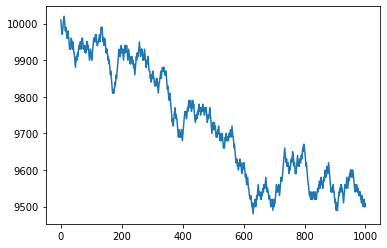

In [48]:

plt.plot(money_changing)
plt.show()


---
### 참고자료
[1] Reinforcement Learning - An Introduction (Richard S. Sutton, Andreow G. Barto), 2nd edition, p.120-124 https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf <br>
[2] matplotlib.pyplot.plot Documentation, https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html <br>
[3] matplotlib.pyplot.plot Examples https://matplotlib.org/tutorials/introductory/pyplot.html